# Import and Define

In [2]:
#Import Packages

import urllib2,json
from bs4 import BeautifulSoup
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import socket
import httplib
import numpy as np
import math
import pymc3 as pm
import theano.tensor as T
from datetime import timedelta 
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [3]:
#Import Sklearn

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model

In [4]:
#Hyponetuse = Distnace of Shot

def distance(x1, y1,x2,y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Get the Data

In [5]:
#GET All Dates and Game Information --- GET GAME IDS

request = urllib2.Request('https://statsapi.web.nhl.com/api/v1/schedule?startDate=2017-12-02&endDate=2018-01-30')
response = urllib2.urlopen(request)
json_load = json.loads(response.read())
#json_normalize(json_load['dates'])
games_dates = json_normalize(data=json_load['dates'], record_path=['games'], meta=['id'],errors='ignore') #SO FUCKING HELPUFL #https://www.kaggle.com/jboysen/quick-tutorial-flatten-nested-json-in-pandas
gamesids = games_dates[games_dates['gameType'] == 'R']['gamePk'] #Only Regular Season
gamesids.reset_index(inplace = True,drop = True)

In [6]:
#GET Plays Broken Out

for x in range(len(gamesids)):
    gameid = gamesids[x]
    url_start = 'https://statsapi.web.nhl.com/api/v1/game/'
    url_end = '/feed/live'
    full_url = url_start + str(gameid) + url_end
    request = urllib2.Request(full_url)
    response = urllib2.urlopen(request)
    json_load = json.loads(response.read())
    if 'Total_Plays' in globals():
        Plays = json_normalize(data=json_load['liveData']['plays']['allPlays'])
        Plays ['gameid'] = gameid
        frames = [Total_Plays,Plays]
        Total_Plays = pd.concat(frames)
    else:
        Total_Plays = json_normalize(data=json_load['liveData']['plays']['allPlays'])
        Total_Plays['gameid'] = gameid

# Total Plays Data

In [7]:
#Previous Play --- You still have not controlled for a bunch of shit but it should be fine given when shots and goals occur

Total_Plays.sort_values(by = ['gameid','about.eventIdx'], axis=0, ascending=True,inplace = True)
Total_Plays['Previous_Play_Game'] = Total_Plays['gameid'].shift()
Total_Plays['Previous_Play'] = np.where(Total_Plays['Previous_Play_Game'] != Total_Plays['gameid'],np.nan,Total_Plays['result.event'].shift())

#Time Shifts 

Total_Plays['about.dateTime'] = Total_Plays['about.dateTime'].astype(str)
Total_Plays['about.dateTime'] = Total_Plays.apply(lambda x: x['about.dateTime'].replace('Z','').replace('T',' '),axis =1)
Total_Plays['about.dateTime'] = pd.to_datetime(Total_Plays['about.dateTime'])
Total_Plays['Previous_Play_Time'] = Total_Plays['about.dateTime'].shift()
#Total_Plays['Previous_Play_Time'] = Total_Plays['Previous_Play_Time'].astype(str)
#Total_Plays['Previous_Play_Time'] = Total_Plays.apply(lambda x: x['Previous_Play_Time'].replace('Z','').replace('T',' '),axis =1)
#Total_Plays['Previous_Play_Time'] = pd.to_datetime(Total_Plays['Previous_Play_Time'])
#Total_Plays['Time_Difference'] = Total_Plays['about.dateTime']-Total_Plays['Previous_Play_Time']
Total_Plays['Time_Difference'] = Total_Plays.apply(lambda r: (r['about.dateTime'] - r['Previous_Play_Time']).total_seconds(),axis = 1)

In [8]:
#Only Full Strength Moments -- Step 1

Total_Plays['Game_Time_Clock'] = (((Total_Plays['about.period'] - 1) * 20) * 60) + (Total_Plays['about.periodTime'].str.split(':').str[0].astype(float) * 60) + Total_Plays['about.periodTime'].str.split(':').str[1].astype(float)
Total_Plays['Penalty_Time'] = np.where(Total_Plays['result.event']  == 'Penalty',Total_Plays['Game_Time_Clock'] + (Total_Plays['result.penaltyMinutes'] * 60),0)
Penalty_Plays = Total_Plays[['gameid','Game_Time_Clock','Penalty_Time']][Total_Plays['Penalty_Time'] != 0]
Penalty_Plays.reset_index(inplace = True,drop = True)

In [9]:
#Define Shot Plays we want Plays
        
Shot_Plays_List = ['SHOT','GOAL']
Total_Plays['Shot_Play_B'] = np.where(Total_Plays['result.eventTypeId'].isin(Shot_Plays_List),1,0)
Total_Plays['Goal_B'] = np.where(Total_Plays['result.eventTypeId'] == 'GOAL',1,0) 
Shot_Plays = Total_Plays[Total_Plays['result.eventTypeId'].isin(Shot_Plays_List)]
Shot_Plays.reset_index(inplace = True, drop = True)

In [10]:
#Get Rid of Penalties -- Step 2

for i in Penalty_Plays.index:
    gameId_penalty = Penalty_Plays['gameid'][i]
    Penalty_Start = Penalty_Plays['Game_Time_Clock'][i]
    Penalty_End = Penalty_Plays['Penalty_Time'][i]
    Shot_Plays = Shot_Plays[~Shot_Plays.index.isin(Shot_Plays[(Shot_Plays['gameid'] == gameId_penalty) & (Shot_Plays['Game_Time_Clock'] >= Penalty_Start) & (Shot_Plays['Game_Time_Clock'] <= Penalty_End)].index)]

# Shot Plays

In [11]:
#Get THe Goal coordiantes

Goal1CoordinateX1 = 89
Goal1CoordinatePP = 3
Goal1CoordinateNP = -3
Goal1CoordinateCG = 0

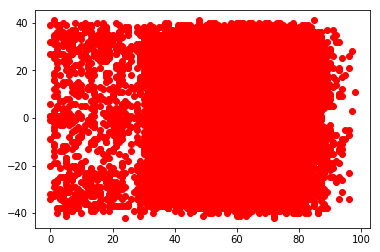

In [12]:
#Flip the Signs --- Because it Needs to be on One Side

Shot_Plays['coordinates.y'] = np.where(Shot_Plays['coordinates.x'] < 0 ,Shot_Plays['coordinates.y'] * -1,Shot_Plays['coordinates.y'])
Shot_Plays['coordinates.x'] = np.where(Shot_Plays['coordinates.x'] < 0 ,Shot_Plays['coordinates.x'] * -1,Shot_Plays['coordinates.x'])
#Shot_Plays = Shot_Plays[Shot_Plays['coordinates.x'] != 89]
#Shot_Plays = Shot_Plays[Shot_Plays['coordinates.y'] != 0] #Get Rid of Things that just wont work. 
plt.plot(Shot_Plays['coordinates.x'],Shot_Plays['coordinates.y'],'ro')

In [13]:
#Distances

Shot_Plays['Horizontal_Distance'] = Shot_Plays.apply(lambda x: Goal1CoordinateX1 - x['coordinates.x'],axis =1)
Shot_Plays['Vertical_Distance'] = Shot_Plays.apply(lambda x: abs(x['coordinates.y']),axis =1)
Shot_Plays['Distance_To_Goal'] = Shot_Plays.apply(lambda x: math.hypot(x['Horizontal_Distance'],x['coordinates.y']),axis =1)
#Shot_Plays['Distance_To_Goal'] = Shot_Plays.apply(lambda x: math.hypot(Goal1CoordinateX1 - x['coordinates.x'],x['coordinates.y']),axis =1)
Shot_Plays['Shot_Distance_NP'] = Shot_Plays.apply(lambda x: distance(x['coordinates.x'],x['coordinates.y'],Goal1CoordinateX1,Goal1CoordinateNP),axis = 1)
Shot_Plays['Shot_Distance_PP'] = Shot_Plays.apply(lambda x: distance(x['coordinates.x'],x['coordinates.y'],Goal1CoordinateX1,Goal1CoordinatePP),axis = 1)
Shot_Plays[['Horizontal_Distance','coordinates.y','Distance_To_Goal']].head(10)

,Horizontal_Distance,coordinates.y,Distance_To_Goal
0,60.0,27.0,65.795137
4,33.0,31.0,45.276926
5,8.0,2.0,8.246211
6,29.0,-29.0,41.012193
7,19.0,-39.0,43.382024
8,58.0,32.0,66.241981
9,36.0,33.0,48.836462
10,12.0,27.0,29.546573
11,37.0,-18.0,41.146081
17,11.0,1.0,11.045361


In [14]:
#Angles

Shot_Plays['Shot_Angle'] = Shot_Plays.apply(lambda row: abs(math.degrees(math.asin(row['coordinates.y']/row['Distance_To_Goal']))) if row['Distance_To_Goal'] > 0 else 180,axis = 1)


# Hierachal Models Begin

In [15]:
#Blocked SHots -- THis is Solved Before

#Blocked_Shots = Shot_Plays[['Blocked_Boolean','Shot_Angle','Vertical_Distance','Horizontal_Distance','Distance_To_Goal']]
#Blocked_Shots = Blocked_Shots[~Blocked_Shots.isin([np.nan, np.inf, -np.inf]).any(1)]
Successful_Shots = Shot_Plays[['Goal_B','Previous_Play','result.secondaryType','Shot_Angle','Distance_To_Goal']]#[Shot_Plays['Blocked_Boolean'] == 0]


In [16]:
#Start Creating Hierachy

one = 'result.secondaryType'
one_names_df = Successful_Shots.groupby(one).all()
names_one  = list()
one_index = Successful_Shots.groupby(one).all().reset_index().reset_index()[['index',one]]
one_index.rename(columns={'index':'index_one'}, inplace=True)
one_indexes = one_index['index_one'].values #For Model
one_count = len(one_indexes) #For Model

#Index Two

two = 'Previous_Play'
two_names_df = Successful_Shots.groupby([one,two]).all()
names_two = list(two_names_df.index)
two_index = Successful_Shots.groupby([one,two]).all().reset_index().reset_index()[['index',one,two]]
two_index.rename(columns={'index':'index_two'},inplace = True)
two_indexes_df = pd.merge(one_index, two_index, how='inner', on= one)
two_indexes = two_indexes_df['index_one'].values #For Model
two_count = len(two_indexes) #For Model

#Combine to Existing

Indexed_Successful_Shot_DF = pd.merge(Successful_Shots, two_indexes_df, how='inner', on=[one,two]).reset_index()

In [17]:
#Model Preminents

observed = Indexed_Successful_Shot_DF['Goal_B']
Shot_Type_Index = Indexed_Successful_Shot_DF['index_one']
N = len(np.unique(Indexed_Successful_Shot_DF['index_one']))
Number_of_Samples = 50000

In [ ]:
#First Model

with pm.Model() as Unpooled_One_Level_One_Variable:

    # Independent parameters for each county
    a = pm.Normal('a', 0, sd=100, shape=N) #Intercept
    b = pm.Normal('b', 0, sd=100, shape=N) #Coefficient for Shot Type

    # Model error
    # Calculate predictions given values
    # for intercept and slope (Comment 4)
    yhat = pm.invlogit(a[Shot_Type_Index] + b[Shot_Type_Index] * Indexed_Successful_Shot_DF.Shot_Angle.values)
 
    # Make predictions fit reality
    y = pm.Binomial('y', n=np.ones(Indexed_Successful_Shot_DF.shape[0]), p=yhat, observed= observed)
    
    #Run It
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace_h = pm.sample(Number_of_Samples, step = step, start = start,njobs = 2)

logp = -5,306.9, ||grad|| = 14.112: 100%|██████████| 457/457 [00:02<00:00, 183.62it/s] 
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [b]
>Metropolis: [a]
 22%|██▏       | 10916/50500 [02:27<08:55, 73.97it/s]

In [ ]:
#Print Stuff
    
burnin = int(Number_of_Samples * .5) #Remove a number of samples from the beginning of the trace. This is know as burn-in. MCMC methods often take some time until we start getting samples from the target distribution. The burn-in will not be necessary for an infinite sample, as it is not part of the Markovian theory. Instead, removing the first samples is an ad hoc trick to get better results given that we are getting a finite sample.
chain = trace_h[burnin:] 
pm.traceplot(chain)

In [ ]:
with pm.Model() as Pooled_One_Level_One_Variable:
    #Hyper Prior
    
    mu_a = pm.StudentT('mu_a', nu=3, mu=0., sd=1.0) 
    sigma_a = pm.HalfNormal('sigma_a', sd=1.0)
    mu_b = pm.StudentT('mu_b', nu=3, mu=0., sd=1.0)
    sigma_b = pm.HalfNormal('sigma_b', sd=1.0)
    
    
    # Independent parameters for each Shot Type
    a = pm.Normal('a',  mu = mu_a, sd=sigma_a, shape=N) #Intercept
    b = pm.Normal('b', mu = mu_b, sd=sigma_b, shape=N) #Coefficient for Shot Type

    # Model error
    # Calculate predictions given values
    # for intercept and slope (Comment 4)
    yhat = pm.invlogit(a[Shot_Type_Index] + b[Shot_Type_Index] * Indexed_Successful_Shot_DF.Shot_Angle.values)
 
    # Make predictions fit reality
    y = pm.Binomial('y', n=np.ones(Indexed_Successful_Shot_DF.shape[0]), p=yhat, observed= observed)
    
    #Run It
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace_h = pm.sample(Number_of_Samples, step = step, start = start,njobs = 1)

In [ ]:
#Print Stuff
    
burnin = int(Number_of_Samples * .5) #Remove a number of samples from the beginning of the trace. This is know as burn-in. MCMC methods often take some time until we start getting samples from the target distribution. The burn-in will not be necessary for an infinite sample, as it is not part of the Markovian theory. Instead, removing the first samples is an ad hoc trick to get better results given that we are getting a finite sample.
chain = trace_h[burnin:] 
pm.traceplot(chain)

In [ ]:
with pm.Model() as Pooled_One_Level_Two_Variable:
    #Hyper Prior
    
    mu_a = pm.StudentT('mu_a', nu=3, mu=0., sd=1.0) 
    sigma_a = pm.HalfNormal('sigma_a', sd=1.0)
    mu_b = pm.StudentT('mu_b', nu=3, mu=0., sd=1.0)
    sigma_b = pm.HalfNormal('sigma_b', sd=1.0)
    mu_c = pm.StudentT('mu_b', nu=3, mu=0., sd=1.0)
    sigma_c = pm.HalfNormal('sigma_b', sd=1.0)
    
    # Independent parameters for each Shot Type
    intercept = pm.Normal('intercept',  mu = mu_a, sd=sigma_a, shape=N) #Intercept
    angle = pm.Normal('angle', mu = mu_b, sd=sigma_b, shape=N) #Coefficient for Shot Type
    distnace = pm.Normal('distnace', mu = mu_c, sd=sigma_c, shape=N) #Coefficient for Shot Type
    
    # Model error
    # Calculate predictions given values
    # for intercept and slope (Comment 4)
    yhat = pm.invlogit(intercept[Shot_Type_Index] + (Indexed_Successful_Shot_DF.Distance_To_Goal.values * distance[Shot_Type_Index]) + (angle[Shot_Type_Index] * Indexed_Successful_Shot_DF.Shot_Angle.values))
 
    # Make predictions fit reality
    y = pm.Binomial('y', n=np.ones(Indexed_Successful_Shot_DF.shape[0]), p=yhat, observed= observed)
    
    #Run It
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace_h = pm.sample(Number_of_Samples, step = step, start = start,njobs = 1)